 #### Work on a vanilla example focussing on time series prediction using LSTM

In [1]:
#import libraries
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from math import sqrt
from pandas import Series
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy

/Users/abhinav.sunderrajan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
#read data and some exploratory plots
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('datasets/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


In [ ]:
# line plot
series.plot()
pyplot.show()

In [6]:
X = series.values
train, test = X[0:-12], X[-12:]

# walk-forward validation
history = [x for x in train]

predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])



RMSE: 136.761


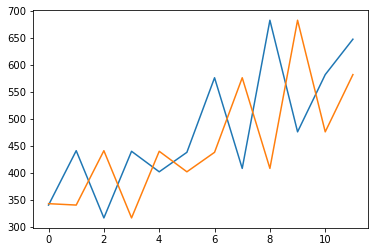

In [7]:
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

In [9]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df


# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


In [10]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

#### Preprocess the data

In [11]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
print(supervised.head())
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

       0      0
0    0.0 -120.1
1 -120.1   37.2
2   37.2  -63.8
3  -63.8   61.0
4   61.0  -11.8


In [12]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2468     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2436     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2408     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2381     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2355     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2328     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2302     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2276     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2250     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2225     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2199     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2173     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2147     
Epoch 1/1
23/23 [=====================

23/23 [==============================] - 0s - loss: 0.1072     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1069     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1066     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1063     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1060     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1057     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1054     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1051     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1049     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1046     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1043     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1040     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.1038     
Epoch 1/1
23/23 [==============================]

23/23 [==============================] - 0s - loss: 0.0784     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0780     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0778     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0779     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0771     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0772     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0767     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0767     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0763     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0761     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0757     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0759     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0751     
Epoch 1/1
23/23 [==============================]

23/23 [==============================] - 0s - loss: 0.0666     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0570     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0571     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0690     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0609     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0668     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0574     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0608     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0901     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0648     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0618     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0685     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0887     
Epoch 1/1
23/23 [==============================]

23/23 [==============================] - 0s - loss: 0.0599     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0593     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0722     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0530     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0551     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0764     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0563     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0554     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0623     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0603     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0724     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0527     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0554     
Epoch 1/1
23/23 [==============================]

23/23 [==============================] - 0s - loss: 0.0564     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0604     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0574     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0570     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0747     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0536     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0541     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0706     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0575     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0632     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0571     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0570     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.0756     
Epoch 1/1
23/23 [==============================]

KeyboardInterrupt: 

In [13]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

NameError: name 'lstm_model' is not defined